In [11]:
import os
from multiprocessing import Pool
import pandas as pd

import rdkit, scipy, xgboost, sklearn
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import DataStructs, Descriptors
from rdkit.Chem import MACCSkeys
from rdkit import Avalon
from rdkit.Avalon import pyAvalonTools

from scipy.spatial.distance import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from rdkit.Chem import PandasTools
import pandas as pd
seed = 1234

In [53]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, make_scorer, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [33]:
for module in [rdkit, scipy, np, pd, sns, sklearn, xgboost]:
    print('{:>12}:{:>10}'.format(module.__name__, module.__version__))


       rdkit: 2018.03.3
       scipy:     1.1.0
       numpy:    1.13.3
      pandas:    0.24.2
     seaborn:     0.9.0
     sklearn:    0.20.1
     xgboost:      0.82


In [103]:
class Dataset2D:
    def __init__(self, data_dir, data_file, y_field=None, id_field=None, ext='sdf'):
        file = os.path.join(data_dir, data_file)
        self.smiles = []
        self.moles = []
        self.Y = [] if y_field is not None else None
        self.id = []
        temp_id = 1
        if ext == 'sdf':
            suppl = Chem.SDMolSupplier(file, strictParsing=False)
            for i in suppl:
                if i is None:
                    continue
                smi = Chem.MolToSmiles(i, isomericSmiles=False)
                if smi is not None and smi != '':
                    self.smiles.append(smi)
                    self.moles.append(i)
                    if y_field is not None:
                        self.Y.append(i.GetProp(y_field))
                    if id_field is not None:
                        self.id.append(i.GetProp(id_field))
                    else:
                        self.id.append('id{:0>5}'.format(temp_id))
                        temp_id += 1
        
        elif ext == 'csv':
            df = pd.read_csv(file)
            df['moles'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
            df = df.dropna()
            self.smiles = df['SMILES'].tolist()
            self.moles = df['moles'].tolist()
            self.Y = df[y_field].tolist()
            self.id = df[id_field].tolist()
            
        else:
            raise ValueError('file extension not supported!')
            
                    
        assert(len(self.smiles) == len(self.moles) == len(self.id))
        if self.Y is not None:
            assert(len(self.smiles) == len(self.Y))
            self.Y = np.array(self.Y)

    
    def __getitem__(self, index):
        if self.Y is not None:
            ret = self.id[index], self.smiles[index], self.moles[index], self.Y[index]
        else:
            ret = self.id[index], self.smiles[index], self.moles[index]
        return ret
    
    def __len__(self):
        return len(self.smiles)
    
    def __add__(self, other):
        pass

In [166]:
class DataStructure:
    def __init__(self, dataset, feat_fn, y_transforms=None, num_proc=1):
        self.dataset = dataset
        self.feat_fn = feat_fn
        self.Y = dataset.Y
        self.id = dataset.id
        self.num_proc = num_proc
        self.feat_names = []
        self.name_to_idx = {}

        x_s = []
        for fname in self.feat_fn.keys():
            f = self.feat_fn[fname]
            with Pool(self.num_proc) as p:
                arr = np.array(p.map(f, self.dataset.moles))
            x_s.append(arr)
            length = arr.shape[1]
            names = list('{}_{}'.format(fname, x+1) for x in range(length))
            self.feat_names += names
        x_s = tuple(x_s)
        self.X_ = np.concatenate(x_s, axis=1)
        # remove any nan rows
        nans = np.isnan(self.X_)
        mask = np.any(nans, axis=1)
        self.X_ = self.X_[~mask, :]
        self.name_to_idx = dict(zip(self.feat_names, range(len(self.feat_names))))
        
        self.id = list(self.id[j] for j in range(len(mask)) if not mask[j])
        if self.Y is not None:
            self.Y = self.Y[~mask]
        if y_transforms is not None:
            for t in y_transforms:
                self.Y = np.array(list(map(t, self.Y)))
    
    def __len__(self):
        return self.X_.shape[0]
    
    @property
    def shape(self):
        return self.X_.shape
    
    def X(self, feats=None):
        '''
        Use a list of to select feature columns
        '''
        if feats is None:
            return self.X_
        else:
            mask = list(map(lambda x: self.name_to_idx[x], feats))
            return self.X_[:, mask]

In [145]:
class ClassifierContainer:
    def __init__(self, name, func, cv_grid, grid_scoring=None, scaler=None,
                 grid_params=None, class_weight=None, n_jobs_grid=4, 
                 random_state=None, **fit_params):
        self.name = name
        self.scaler = scaler
        self.func = func
        self.grid_params = grid_params
        self.fit_params = fit_params
        self.cv_grid = cv_grid
        self.n_jobs_grid = n_jobs_grid
        self.grid_scoring = grid_scoring
        self.grc = None
        self.model = func(random_state=random_state, class_weight=class_weight, **fit_params)
        if self.grid_params is not None:
            self.grc = GridSearchCV(self.model, 
                                    self.grid_params, n_jobs=self.n_jobs_grid, scoring=self.grid_scoring, 
                                    cv=self.cv_grid, verbose=1)
        self.best_params = None
        
        
    def grid_search(self, X, y):
        if self.scaler is not None:
            X = self.scaler.fit_transform(X)
        self.grc.fit(X, y)
        self.best_params = self.grc.best_params_
        self.model = self.grc.best_estimator_
    
    def fit(self, X, y):
        if self.scaler is not None:
            X = self.scaler.fit_transform(X)
        self.model.fit(X, y)
        
    def predict(self, X):
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return self.model.predict(X)

In [112]:
def get_class(y, thres=7.4):
    return labels[1] if y >= thres else labels[0]

In [39]:
#Morgan fps
def morganX(mol, bits=2048, radius=2):
    morgan = np.zeros((1, bits))
    fp = Chem.GetMorganFingerprintAsBitVect(mol, radius, nBits=bits)
    DataStructs.ConvertToNumpyArray(fp, morgan)
    return morgan

#MACCS
def maccsX(mol):
    maccs = np.zeros((1,167))
    fp = MACCSkeys.GenMACCSKeys(mol)
    DataStructs.ConvertToNumpyArray(fp, maccs)
    return maccs

#Avalon fps
def avalonX(mol, avbits=512):
    avalon = np.zeros((1, avbits))
    fp = pyAvalonTools.GetAvalonFP(mol)
    DataStructs.ConvertToNumpyArray(fp, avalon)
    return avalon

# physchem descriptors
def descriptorsX(m):
    descr = [Descriptors.ExactMolWt(m),
             Descriptors.MolLogP(m),
             Descriptors.TPSA(m),
             Descriptors.NumHAcceptors(m),
             Descriptors.NumHDonors(m),
             Descriptors.NumRotatableBonds(m),
             Descriptors.NumHeteroatoms(m),
             Descriptors.NumAromaticRings(m),
             Descriptors.FractionCSP3(m)]
    return np.array(descr)

### Load dataset

In [60]:
model_dir = '.'
data_dir = '.'
data_file = 'Glycogen.csv'
labels = {0: '0', 1: '1'}

In [140]:
ds = Dataset2D(data_dir, data_file, y_field='pIC50', id_field='CMPD_CHEMBLID', ext='csv')

In [167]:
%%time
data_str = DataStructure(ds, dict(maccs=maccsX, morgan=morganX, avalon=avalonX, phys=descriptorsX), 
                         num_proc=8, y_transforms=[float, lambda x: get_class(x, thres=7.0)])

CPU times: user 595 ms, sys: 597 ms, total: 1.19 s
Wall time: 2.7 s


In [171]:
# Select different features
data_str.X(['morgan_1', 'phys_1'])[:3,:]

array([[   0.        ,  359.0308981 ],
       [   0.        ,  353.1461041 ],
       [   0.        ,  384.17706988]])

In [116]:
# Remove low variance columns
sel = VarianceThreshold(threshold=0.0)

In [172]:
X = data_str.X()
y = data_str.Y
X = sel.fit_transform(X)

In [173]:
idx_train, idx_test = train_test_split(np.arange(len(data_str)), test_size=0.20, random_state=seed)

In [174]:
X_train = X[idx_train]
X_test = X[idx_test]
y_train = y[idx_train]
y_test = y[idx_test]

In [175]:
X_train.shape

(1404, 2598)

### All classifiers

In [121]:
num_proc = os.cpu_count()

In [122]:
cv = StratifiedKFold(n_splits=5, random_state=seed)

In [123]:
# Not using X-scaling for RF
models = [
    ('Random Forest', RandomForestClassifier, None, {"max_features": [int(np.sqrt(X_train.shape[1])),
                                                                      X_train.shape[1] // 3], 
              "n_estimators": [500, 1000]}, {'criterion': 'entropy', 'oob_score': True, 'n_estimators': 500, 'n_jobs': num_proc}),
    
    ('SVM Classification', SVC, StandardScaler(), {'C': [1, 5, 10], 'gamma': [0.001, 0.01, 0.1]}, 
                           {'kernel':'rbf', 'probability':True}),
    
    ('XGB', XGBClassifier, StandardScaler(), {'max_depth': [4, 6, 8, 10], 'learning_rate': [0.1, 0.05, 0.01],  
#                             'colsample_bytree': [1.0, 0.9, 0.8], 'colsample_bylevel': [1.0, 0.9, 0.8]
                           }, 
     {'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 8, 'n_jobs': num_proc}),
    
    ('Logistic Regression', LogisticRegressionCV, StandardScaler(), { 'solver': ['newton-cg', 'lbfgs']}, 
    {'max_iter': 1000, 'n_jobs': num_proc, 'cv': 5}),
]

In [124]:
classifiers = {}
for m in models:
    name, func, scaler, grid_params, fit_params = m
    print(name)
    classifier = ClassifierContainer(name, func, cv, grid_params=grid_params, scaler=scaler, n_jobs_grid=8,
                            grid_scoring=make_scorer(matthews_corrcoef), class_weight='balanced',
                            random_state=seed, **fit_params
                           )
    classifiers[name] = classifier

Random Forest
SVM Classification
XGB
Logistic Regression


### Fit the models

In [125]:
MODE = 'Fit'
for name in classifiers.keys():
    model = classifiers[name]
    print(name)
    if MODE == 'Grid':
        model.grid_search(X_train, y_train)
    elif MODE == 'Fit':
        model.fit(X_train, y_train)  
    else:
        raise ValueError('Not valid mode')

Random Forest
SVM Classification
XGB
Logistic Regression


### Test performance by cross validation

In [126]:
cv_cv = StratifiedKFold(n_splits=10, random_state=seed)
acc = {}
mcc = {}
kap ={}

for name in classifiers.keys():
    print(name)
    model = classifiers[name]
    scaler = model.scaler
    clf = model.model if scaler is None else make_pipeline(scaler, model.model)
    cv_result = cross_validate(clf, X, y, cv=cv_cv,
                           scoring={'Accuracy': make_scorer(accuracy_score), 'MCC': make_scorer(matthews_corrcoef), 
                                    'kappa': make_scorer(cohen_kappa_score)},
                           return_train_score=True)
    acc[name] = cv_result['test_Accuracy']
    mcc[name] = cv_result['test_MCC']
    kap[name] = cv_result['test_kappa']

Random Forest
SVM Classification
XGB
Logistic Regression


In [127]:
acc_df = pd.DataFrame(acc)
mcc_df = pd.DataFrame(mcc)
kap_df = pd.DataFrame(kap)

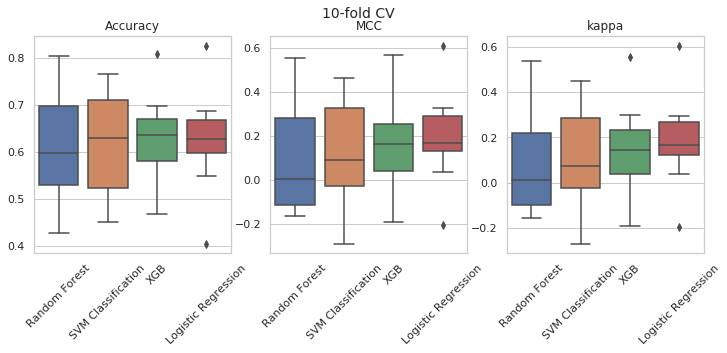

In [128]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('10-fold CV', fontsize=14)

axs[0].set_title('Accuracy')
axs[1].set_title('MCC')
axs[2].set_title('kappa')

sns.boxplot(data=acc_df, ax=axs[0])
sns.boxplot(data=mcc_df, ax=axs[1])
sns.boxplot(data=kap_df, ax=axs[2])

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


### Test performance using the test set

In [129]:
for name in classifiers.keys():
    model = classifiers[name]
    pred = model.predict(X_test)
    print(name)
    print("Accuracy = {:.2f}".format(accuracy_score(y_test, pred)))
    print("MCC = {:.2f}".format(matthews_corrcoef(y_test, pred)))
    print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, pred)))
    print('------------------------')
    print()

Random Forest
Accuracy = 0.83
MCC = 0.61
Kappa = 0.61
------------------------

SVM Classification
Accuracy = 0.79
MCC = 0.56
Kappa = 0.55
------------------------

XGB
Accuracy = 0.84
MCC = 0.65
Kappa = 0.65
------------------------

Logistic Regression
Accuracy = 0.80
MCC = 0.57
Kappa = 0.56
------------------------



Text(0.5, 1.0, 'XGB model')

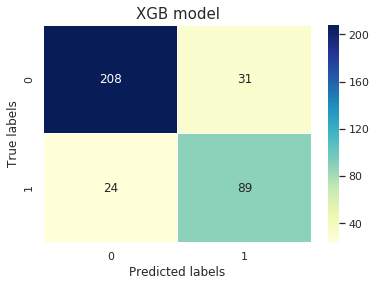

In [133]:
name = 'XGB'
clf = classifiers[name]
pred_clf = clf.predict(X_test)
labs = list(labels.values())
cnf_matrix = confusion_matrix(np.asarray(y_test), pred_clf, labels=labs)
ax = sns.heatmap(cnf_matrix, annot=True, ax = None, linewidths=.5, cmap="YlGnBu",
                xticklabels=list(labels.keys()), yticklabels=labs, fmt='d')

ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12); 
ax.set_title('{} model'.format(name), fontsize=15)